In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from GPyEm import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


seed = 7
#set_seed(seed)

In [2]:
mesh=37
y_val = torch.tensor([134,92])

In [3]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_13/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_'+str(mesh)+'/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

     CV_ventricles  k_ventricles    k_FEC  CV_atria   k_atria     k_BB
0         0.606444      0.442714  5.53288  0.317814  0.376440  1.35358
1         0.518476      0.304389  6.83032  0.628421  0.237364  1.25791
2         0.641101      0.239081  5.82181  1.020680  0.437033  5.30559
3         0.750099      0.373713  4.49537  0.526532  0.444927  2.07317
4         0.689263      0.388615  2.34609  0.556797  0.477035  2.36587
..             ...           ...      ...       ...       ...      ...
115       0.545148      0.260282  1.41140  0.982380  0.242211  2.02864
116       0.407284      0.272427  1.55631  0.353259  0.340049  1.65963
117       0.796166      0.465371  7.16628  0.539272  0.228129  1.68568
118       0.752534      0.476168  3.40841  0.386740  0.264407  5.40274
119       0.687991      0.318799  6.32706  0.767307  0.234231  4.38626

[120 rows x 6 columns]


In [4]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_13/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP/scenario_'+str(mesh)+'/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

        A_TAT     V_TAT
0    296.1940  106.6400
1    170.7960  140.4090
2     63.1401  122.1590
3    148.6480   92.1577
4    133.1920  101.1890
..        ...       ...
115   95.0785  162.8840
116  252.4290  211.9730
117  186.7530   78.9568
118  195.6280   85.1879
119  104.5540  104.2000

[120 rows x 2 columns]


# Emulator

In [5]:
y_all.max()

A_TAT    312.285
V_TAT    224.775
dtype: float64

In [6]:
input_masked = X_all.copy()

In [7]:
y_all

,A_TAT,V_TAT
0,296.1940,106.6400
1,170.7960,140.4090
2,63.1401,122.1590
3,148.6480,92.1577
4,133.1920,101.1890
...,...,...
115,95.0785,162.8840
116,252.4290,211.9730
117,186.7530,78.9568
118,195.6280,85.1879


In [8]:
y_train = torch.tensor(y_all.values)
x_train = torch.tensor(X_all[0:y_all.shape[0]].values)

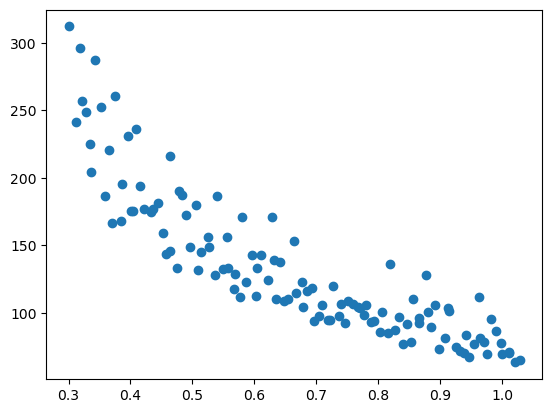

In [9]:
plt.plot(x_train[:,3],y_train[:,0],'o')

In [10]:
y_train

tensor([[296.1940, 106.6400],
        [170.7960, 140.4090],
        [ 63.1401, 122.1590],
        [148.6480,  92.1577],
        [133.1920, 101.1890],
        [132.5730,  91.6085],
        [ 93.5819, 177.4280],
        [106.4450, 133.8390],
        [ 69.9348, 101.1370],
        [ 76.8217, 143.0310],
        [109.8770, 109.3990],
        [176.8380, 143.9360],
        [ 78.2424, 130.4050],
        [ 97.4448, 176.8830],
        [ 93.6578, 122.3940],
        [159.2310,  95.8223],
        [143.1260,  90.5206],
        [103.9100, 111.5330],
        [187.0040, 224.7750],
        [ 96.0024,  89.7075],
        [ 70.5650, 100.6570],
        [ 77.6447, 144.4530],
        [287.4870, 162.1430],
        [156.4700, 157.4960],
        [ 70.4692, 126.2010],
        [248.6590, 130.6360],
        [ 93.2842, 175.0540],
        [ 64.6096, 112.3900],
        [111.5360,  99.6606],
        [110.0210, 159.6500],
        [110.1640, 112.7550],
        [175.0150, 118.9460],
        [ 85.6613,  94.4889],
        [1

In [11]:
x_train.shape

torch.Size([120, 6])

In [12]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1


In [13]:
nDim = input_masked.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(input_masked.iloc[:,i]),np.max(input_masked.iloc[:,i])])
    print(boundsMaxMin[i])

[0.382351, 0.799717]
[0.201679, 0.499831]
[1.24091, 8.38479]
[0.300623, 1.02851]
[0.200837, 0.497599]
[1.01838, 5.67135]


In [14]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = torch.tensor(param_values)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_44845/2553582652.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [15]:
data1.shape

torch.Size([14336, 6])

In [16]:
Si = []
nMod = y_all.shape[1]
nDim = input_masked.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                        ST   ST_conf
(CV_ventricles,)  0.000020  0.000004
(k_ventricles,)   0.000046  0.000009
(k_FEC,)          0.000294  0.000066
(CV_atria,)       0.880296  0.057573
(k_atria,)        0.041651  0.004435
(k_BB,)           0.093348  0.010403
                        S1   S1_conf
(CV_ventricles,)  0.000027  0.000391
(k_ventricles,)   0.000215  0.000528
(k_FEC,)         -0.000011  0.001417
(CV_atria,)       0.861653  0.079898
(k_atria,)        0.035900  0.016720
(k_BB,)           0.083794  0.032027
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST   ST_conf
(CV_ventricles,)  0.823782  0.060453
(k_ventricles,)   0.151204  0.013423
(k_FEC,)          0.034874  0.004914
(CV_atria,)       0.000198  0.000043
(k_atria,)        0.000150  0.000027
(k_BB,)           0.000129  0.000026
                        S1   S1_conf
(CV_ventricles,)  0.814955  0.068654
(k_ventricles,)   0.143933  0.037585
(k_FEC,)          0.028510  0.017146
(CV_atria,)      -0.000187

In [17]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


In [18]:
x_labels.values.squeeze().tolist()

['CV_ventricles', 'k_ventricles', 'k_FEC', 'CV_atria', 'k_atria', 'k_BB']

In [19]:
y_all.columns.tolist()

['A_TAT', 'V_TAT']

In [20]:
['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

['PCa_b',
 'Tref',
 'perm50',
 'CV_ventricles',
 'a_ventricles',
 'EDP_lv',
 'EDP_rv',
 'Rsys',
 'Rpulm']

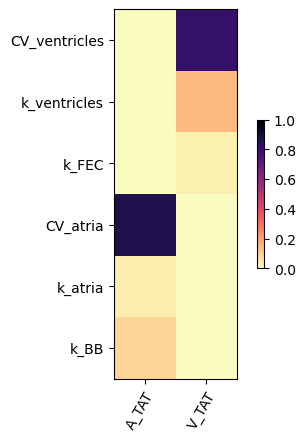

In [21]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_xticks(np.arange(len(outputs)),labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

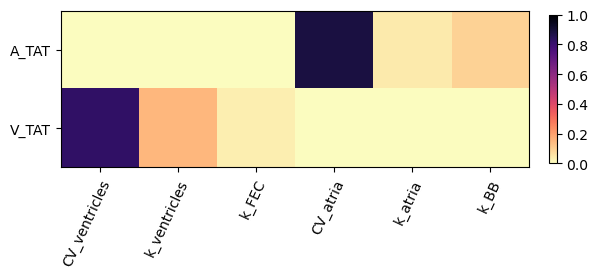

In [22]:
inputs = X_all.columns.tolist()
outputs = y_all.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T[0:28],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=65, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [23]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [24]:
boundsMaxMin

[[0.382351, 0.799717],
 [0.201679, 0.499831],
 [1.24091, 8.38479],
 [0.300623, 1.02851],
 [0.200837, 0.497599],
 [1.01838, 5.67135]]

In [25]:
centre[[1,2,4,5,]]

array([0.350755, 4.81285 , 0.349218, 3.344865])

In [26]:
boundsMaxMin=np.array(boundsMaxMin)

In [27]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        return 0.0
    return -np.inf

In [28]:
def log_likelihood(x,emulator,y_val,obs_error):
    x=torch.tensor(x)[None]
    with gpytorch.settings.fast_pred_var(): #This line makes it fast!
        ll =np.sum((emulator.ensemble_log_likelihood_obs_error(x,y_val[None,:],obs_error)).detach().numpy())
    return ll

In [29]:
def log_prob(theta, emulator,y_val,obs_error):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf

    return lp + log_likelihood(theta,emulator, y_val,obs_error)

In [30]:
y_val[None,:]

tensor([[134,  92]])

In [31]:
torch.tensor([1,0,1,0,0,0])[None].shape

torch.Size([1, 6])

In [32]:
emulator.ensemble_log_likelihood_obs_error(torch.tensor([1,0,1,0,0,0])[None],y_val[None,:],torch.tensor([1,1,1,1,1,0]))

tensor([[-167.1058],
        [  -6.5930]], grad_fn=<CopySlices>)

In [33]:
import emcee

In [34]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2
ndim = input_masked.shape[1]
nwalkers = 18
p0 = np.random.uniform(0,1,(nwalkers,ndim))*(np.array(boundsMaxMin)[:,1]-np.array(boundsMaxMin)[:,0])+np.array(boundsMaxMin)[:,0]
#y_val = torch.tensor([80,134])
obs_error=((y_val*0.05))**2

In [35]:
y_val+2*((y_val*0.05))

tensor([147.4000, 101.2000])

In [36]:
y_val*0.18

tensor([24.1200, 16.5600])

In [37]:
obs_error

tensor([44.8900, 21.1600])

In [39]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val,obs_error])

sampler.run_mcmc(p0, 10000,progress=True)

100%|███████████████████████████████████| 10000/10000 [02:08<00:00, 77.78it/s]


State([[0.69125947 0.4482573  5.74103478 0.59675404 0.29075597 4.54226699]
 [0.79522494 0.23897028 5.67114049 0.53098419 0.32295837 3.76606754]
 [0.66776376 0.48527499 8.28262565 0.62611731 0.38520758 2.39276176]
 [0.72099244 0.38015277 7.17369994 0.65935881 0.20408323 5.62876369]
 [0.76586653 0.40675189 8.178911   0.56858085 0.2452966  3.98905979]
 [0.69399222 0.46825591 4.40583388 0.75756565 0.29119251 1.1082277 ]
 [0.77456298 0.39965002 1.81051501 0.65306202 0.21291794 4.59716341]
 [0.76960787 0.34625546 3.52398414 0.68075716 0.22303778 2.2087895 ]
 [0.72894811 0.49271568 2.31066519 0.59745885 0.28698665 3.60372752]
 [0.75496012 0.46931843 6.98904895 0.60826324 0.33516026 3.18094274]
 [0.71955163 0.41244367 4.86315835 0.59381285 0.33598748 2.66317392]
 [0.67710518 0.3321298  6.89311417 0.51270855 0.35090871 3.81389553]
 [0.67006641 0.43383498 6.94757296 0.45337607 0.43579812 4.61716063]
 [0.79716614 0.32575284 3.78078589 0.76515582 0.21763245 3.38566001]
 [0.76616608 0.27941886 6.87

In [40]:
flat_samples = sampler.get_chain(discard=2000, thin=10, flat=True)
print(flat_samples.shape)

(14400, 6)


In [43]:
y_val.shape

torch.Size([2])

In [45]:
emulator.ensemble_log_likelihood_obs_error(torch.tensor(flat_samples),y_val[None],[0.01,0.01])

tensor([[-12.4491,  -1.7873,  -4.6959,  ...,  -2.8317,  -7.6970,  -1.6700],
        [-21.9952,  -5.4729, -54.6612,  ...,  -0.9949,  -4.2552, -18.0511]],
       grad_fn=<CopySlices>)

In [42]:
boundsMaxMin

array([[0.382351, 0.799717],
       [0.201679, 0.499831],
       [1.24091 , 8.38479 ],
       [0.300623, 1.02851 ],
       [0.200837, 0.497599],
       [1.01838 , 5.67135 ]])

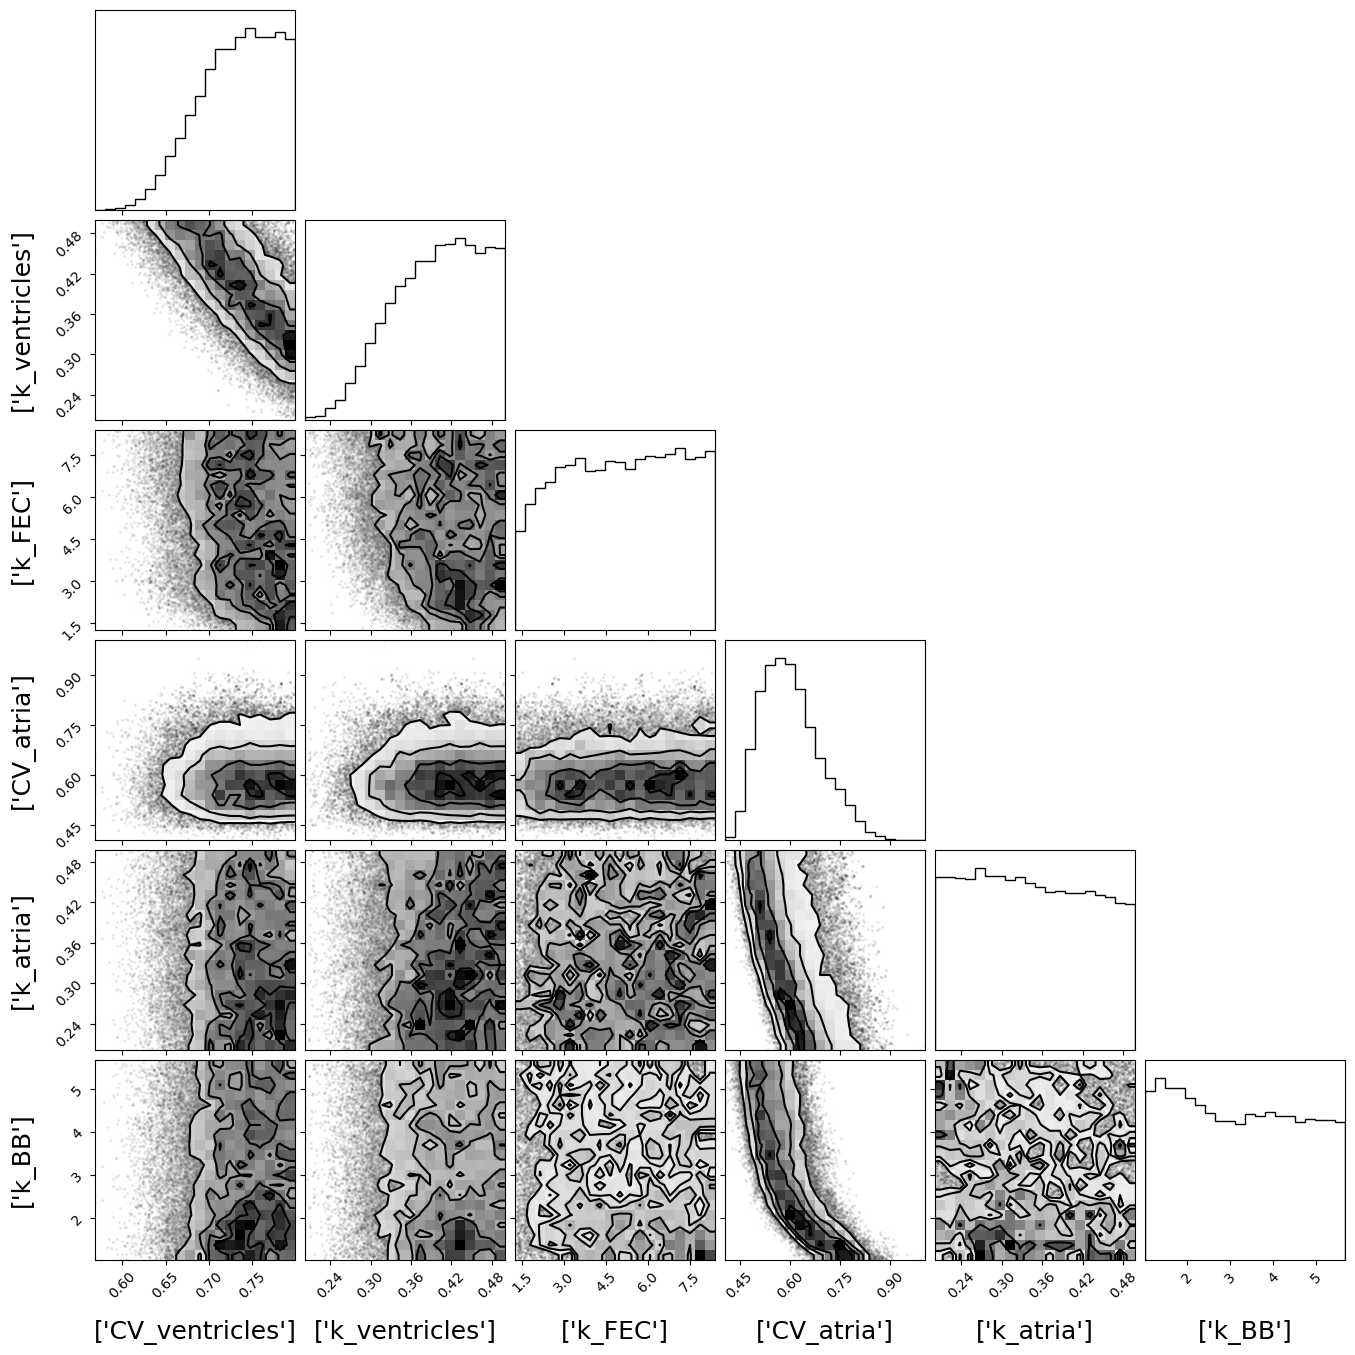

In [43]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

(array([4.0000e+00, 1.3100e+02, 1.0320e+03, 4.6450e+03, 1.0390e+04,
        1.1658e+04, 6.2780e+03, 1.6110e+03, 2.3500e+02, 1.6000e+01]),
 array([102.69109344, 108.63818359, 114.58527374, 120.53236389,
        126.47945404, 132.42654419, 138.37362671, 144.32072449,
        150.26780701, 156.21490479, 162.1619873 ]),
 <BarContainer object of 10 artists>)

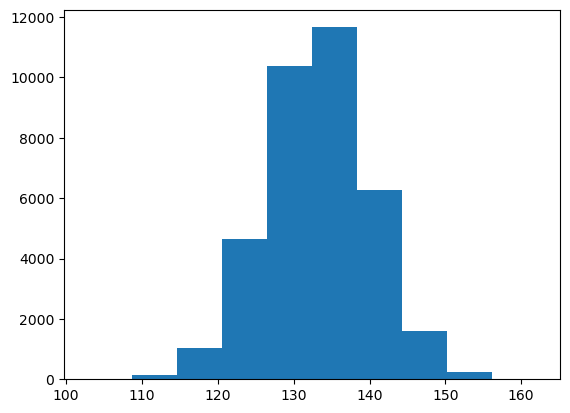

In [44]:
plt.hist(emulator.predict(torch.tensor(flat_samples)).detach().numpy()[:,0])

In [45]:
emulator.predict(torch.tensor(flat_samples)).mean(axis=0)

tensor([133.2545,  93.1014], grad_fn=<MeanBackward1>)

In [46]:
emulator.predict(torch.tensor(flat_samples)).std(axis=0)

tensor([6.8622, 4.3612], grad_fn=<StdBackward0>)

In [47]:
y_val*0.05

tensor([6.7000, 4.6000])

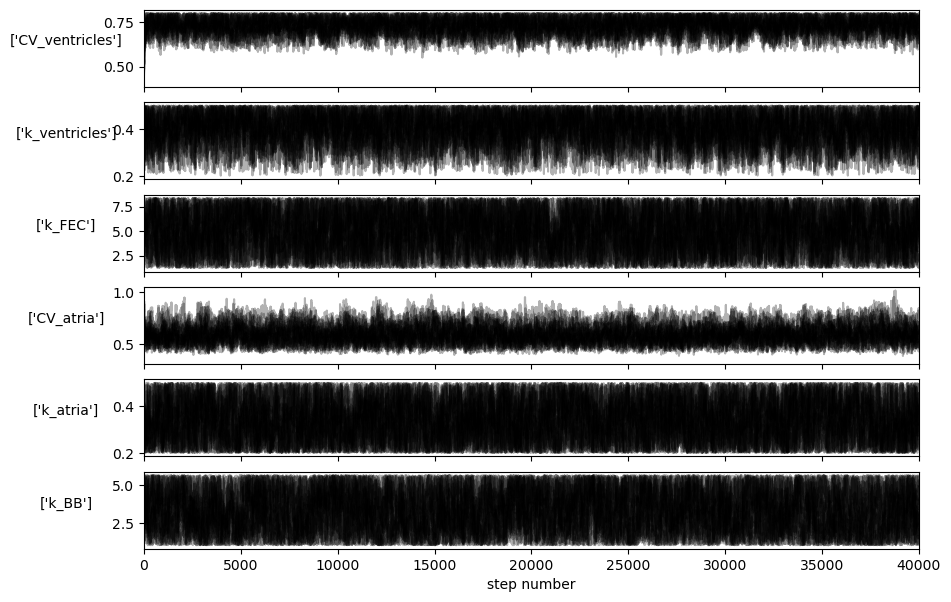

In [48]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [49]:
y_all.min()

A_TAT    63.1401
V_TAT    78.9568
dtype: float64

In [50]:
flat_samples.mean(axis=0)-flat_samples.std(axis=0)

array([0.6887675 , 0.33517553, 3.00201519, 0.51568963, 0.25952218,
       1.88594147])

In [51]:
flat_samples.mean(axis=0)+flat_samples.std(axis=0)

array([0.77518669, 0.46218532, 7.00964553, 0.68938166, 0.42958204,
       4.60958484])

In [52]:
boundsMaxMin

array([[0.382351, 0.799717],
       [0.201679, 0.499831],
       [1.24091 , 8.38479 ],
       [0.300623, 1.02851 ],
       [0.200837, 0.497599],
       [1.01838 , 5.67135 ]])

In [53]:
emulator.predict(torch.tensor(flat_samples.mean(axis=0))[None])

tensor([[124.4595,  92.0572]], grad_fn=<PermuteBackward0>)

In [54]:
torch.tensor(flat_samples.mean(axis=0))[None]

tensor([[0.7320, 0.3987, 5.0058, 0.6025, 0.3446, 3.2478]], dtype=torch.float64)